In [1]:
# %load ../init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys
import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
import kalepy.utils
import kalepy.plot

import holodeck as holo
import holodeck.sam
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, MPC, GYR

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode
plt.rcParams.update({'grid.alpha': 0.5})

log = holo.log
log.setLevel(logging.INFO)

# Quick Start

Construct a Semi-Analytic Model (SAM) using all of the default parameters

In [2]:
sam = holo.sam.Semi_Analytic_Model()

Choose the edges of the frequency bins at which to calculate the GWB

In [ ]:
fobs = utils.nyquist_freqs(10.0*YR, 0.2*YR)
print(f"Number of frequency bins: {fobs.size-1}")
print(f"  between [{fobs[0]*YR:.2f}, {fobs[-1]*YR:.2f}] 1/yr")
print(f"          [{fobs[0]*1e9:.2f}, {fobs[-1]*1e9:.2f}] nHz")

Calculate GWB at given observed GW frequencies (`fobs`) for many different realizations to get a distribution of spectra

In [ ]:
gwb = sam.gwb(fobs, realize=500)    # calculate many different realizations

Plot GWB over multiple realizations

In [ ]:
nsamp = 5    # number of sample GWB spectra to plot
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', ylabel='Characteristic Strain $h_c$')

# `fobs` are bin edges in CGS units, convert to [1/yr], and get midpoints for plotting
xx = fobs * YR
xx = 0.5 * (xx[1:] + xx[:-1])

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0)

# Plot the median GWB spectrum
ax.plot(xx, np.median(gwb, axis=-1), 'k-')

# Plot `nsamp` random spectra 
nsamp = np.min([nsamp, gwb.shape[1]])
idx = np.random.choice(gwb.shape[1], nsamp, replace=False)
ax.plot(xx, gwb[:, idx], 'k-', lw=1.0, alpha=0.1)

# plot contours at 50% and 98% confidence intervals
for pp in [50, 98]:
    percs = pp / 2
    percs = [50 - percs, 50 + percs]
    ax.fill_between(xx, *np.percentile(gwb, percs, axis=-1), alpha=0.25, color='b')

plt.show()

# build SAM component-by-component

Construct the four components required for all SAM models:

1) **Galaxy Stellar Mass Function (GSMF)**: number-density of galaxies as a function of stellar mass
2) **Galaxy Pair Fraction (GPF)**: fraction of galaxies that are in pairs
3) **Galaxy Merger Time (GMT)**: time it takes for galaxies to merge
4) **MBH––Galaxy Scaling Relationship (e.g. Mbh-Mbulge)**: mapping between galaxy properties (i.e. stellar mass) and BH mass

In [ ]:
gsmf = holo.sam.GSMF_Schechter()        # Galaxy Stellar-Mass Function (GSMF)
gpf = holo.sam.GPF_Power_Law()          # Galaxy Pair Fraction         (GPF)
gmt = holo.sam.GMT_Power_Law()          # Galaxy Merger Time           (GMT)
mmbulge = holo.relations.MMBulge_MM2013() # M-MBulge Relation            (MMB)

Build SAM using these components

In [ ]:
sam_bycomp = holo.sam.Semi_Analytic_Model(gsmf=gsmf, gpf=gpf, gmt=gmt, mmbulge=mmbulge)

In [ ]:
np.allclose(sam.grid,sam_bycomp.grid)

### Calculate the distribution of GWB Amplitudes at 1/yr

In [3]:
fobs_yr = 1.0/YR
fobs_yr = fobs_yr * (1.0 + np.array([-0.05, 0.05]))
ayr = sam.gwb(fobs_yr, realize=500)
#ayr_bycomp = sam_bycomp.gwb(fobs_yr, realize=500)

Plot the distribution

In [ ]:
fig, ax = plt.subplots(figsize=[8, 4])
ax.set(xlabel=r'$\log_{10}(A_\mathrm{yr})$', ylabel='Probability Density')
ax.grid(alpha=0.2)

# use `kalepy` do draw the 1D distribution
kale.dist1d(np.log10(ayr), density=True, confidence=True)
#kale.dist1d(np.log10(ayr_bycomp), density=True, confidence=True)

plt.show()

# Generate Full Population of Binaries

In [4]:
# Choose a hardening model (determines number of binaries in each frequency bin)
hard = holo.evolution.Hard_GW()

In [11]:
# Sample the SAM population using 'outlier sampling'
#vals, weights, edges, dens, mass = holo.sam.sample_sam_with_hardening(sam, hard, fobs=fobs, sample_threshold=1e2, poisson_inside=True, poisson_outside=True)
nsamples=500
gwtot_samp_yr = np.zeros(nsamples)
for i in range(nsamples):
    vals, weights, edges, dens, mass = holo.sam.sample_sam_with_hardening(sam, hard, fobs=fobs_yr, sample_threshold=1e2, poisson_inside=True, poisson_outside=True)
    # multiplying by 2 here b/c of inconsistency between observed frequencies and gw frequencies -- need to fix
    gff_samp, gwf_samp, gwb_samp = holo.gravwaves._gws_from_samples(vals, weights, fobs_yr*2)
    #print(fobs_yr)
    #print(gwf_samp,gwb_samp)
    # add foreground and background in quadrature to get total amplitude
    gwtot_samp_yr[i] = np.sqrt(gwf_samp**2 + gwb_samp**2)
    #print(np.log10(gwtot_samp))

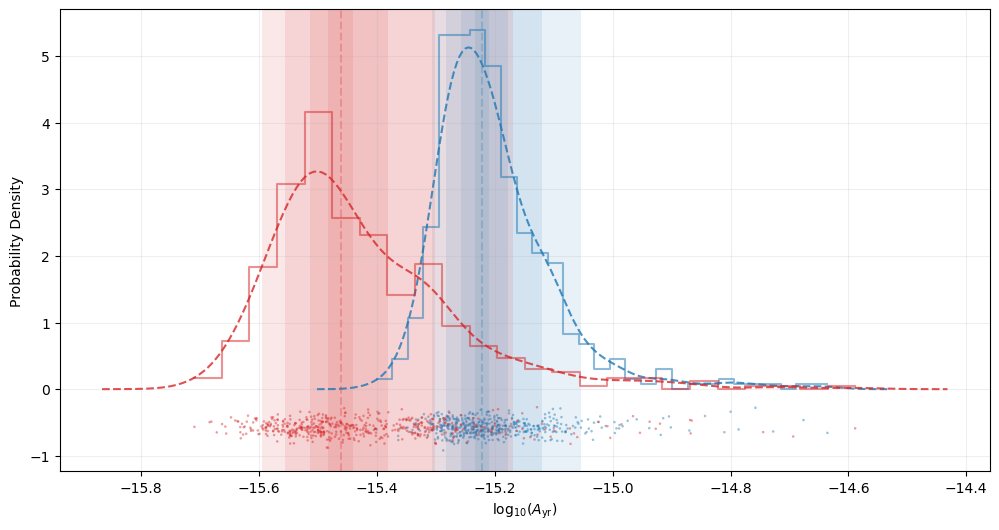

In [12]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.set(xlabel=r'$\log_{10}(A_\mathrm{yr})$', ylabel='Probability Density')
ax.grid(alpha=0.2)

# use `kalepy` do draw the 1D distribution
kale.dist1d(np.log10(ayr), density=True, confidence=True)
#comparing the SAM and the full binary population at a single frequency (yr^-1)
kale.dist1d(np.log10(gwtot_samp_yr), density=True, confidence=True)
plt.show()

### Calculate the distribution of GWB Amplitudes at 1/(3 yr)

In [5]:
fobs_3yr = 1.0/(3.0*YR)
fobs_3yr = fobs_3yr * (1.0 + np.array([-0.05, 0.05]))
a3yr = sam.gwb(fobs_3yr, realize=500)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 4])
ax.set(xlabel=r'$\log_{10}(A_\mathrm{yr})$', ylabel='Probability Density')
ax.grid(alpha=0.2)

# use `kalepy` do draw the 1D distribution
kale.dist1d(np.log10(a3yr), density=True, confidence=True)
#kale.dist1d(np.log10(ayr_bycomp), density=True, confidence=True)

plt.show()

In [9]:
# Sample the SAM population using 'outlier sampling'
#vals, weights, edges, dens, mass = holo.sam.sample_sam_with_hardening(sam, hard, fobs=fobs, sample_threshold=1e2, poisson_inside=True, poisson_outside=True)
nsamples=500
gwtot_samp_3yr = np.zeros(nsamples)
for i in range(nsamples):
    vals, weights, edges, dens, mass = holo.sam.sample_sam_with_hardening(sam, hard, fobs=fobs_3yr, sample_threshold=1e2, poisson_inside=True, poisson_outside=True)
    # multiplying by 2 here b/c of inconsistency between observed frequencies and gw frequencies -- need to fix
    gff_samp, gwf_samp, gwb_samp = holo.gravwaves._gws_from_samples(vals, weights, fobs_3yr*2)
    # add foreground and background in quadrature to get total amplitude
    gwtot_samp_3yr[i] = np.sqrt(gwf_samp**2 + gwb_samp**2)

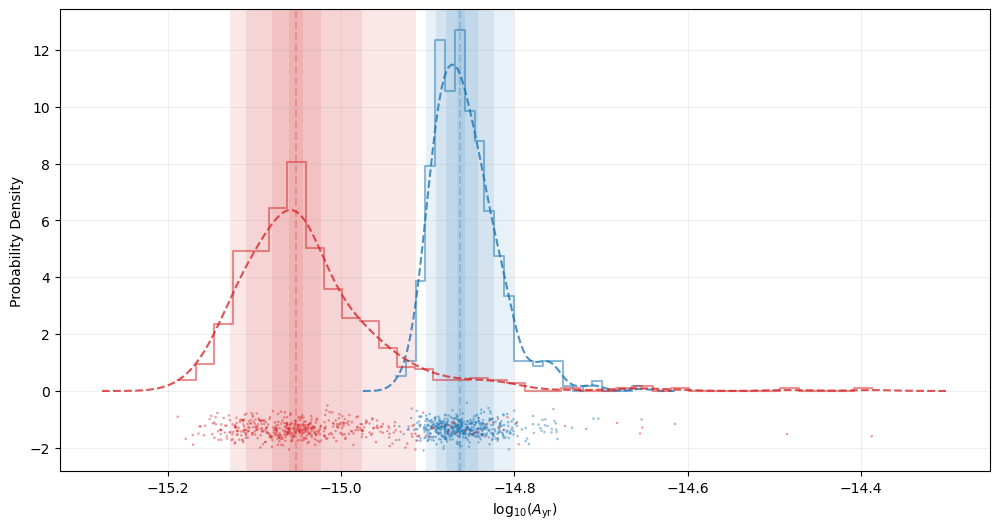

In [10]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.set(xlabel=r'$\log_{10}(A_\mathrm{yr})$', ylabel='Probability Density')
ax.grid(alpha=0.2)

# use `kalepy` do draw the 1D distribution
kale.dist1d(np.log10(a3yr), density=True, confidence=True)
#comparing the SAM and the full binary population at a single frequency (yr^-1)
kale.dist1d(np.log10(gwtot_samp_3yr), density=True, confidence=True)
plt.show()

### Calculate the distribution of GWB Amplitudes at 1/(0.3 yr)

In [6]:
fobs_pt3yr = 1.0/(0.3*YR)
fobs_pt3yr = fobs_pt3yr * (1.0 + np.array([-0.05, 0.05]))
apt3yr = sam.gwb(fobs_pt3yr, realize=500)

In [ ]:
fig, ax = plt.subplots(figsize=[8, 4])
ax.set(xlabel=r'$\log_{10}(A_\mathrm{yr})$', ylabel='Probability Density')
ax.grid(alpha=0.2)

# use `kalepy` do draw the 1D distribution
kale.dist1d(np.log10(apt3yr), density=True, confidence=True)
#kale.dist1d(np.log10(ayr_bycomp), density=True, confidence=True)

plt.show()

In [7]:
# Sample the SAM population using 'outlier sampling'
nsamples=500
gwtot_samp_pt3yr = np.zeros(nsamples)
for i in range(nsamples):
    vals, weights, edges, dens, mass = holo.sam.sample_sam_with_hardening(sam, hard, fobs=fobs_pt3yr, sample_threshold=1e2, poisson_inside=True, poisson_outside=True)
    # multiplying by 2 here b/c of inconsistency between observed frequencies and gw frequencies -- need to fix
    gff_samp, gwf_samp, gwb_samp = holo.gravwaves._gws_from_samples(vals, weights, fobs_pt3yr*2)
    # add foreground and background in quadrature to get total amplitude
    gwtot_samp_pt3yr[i] = np.sqrt(gwf_samp**2 + gwb_samp**2)

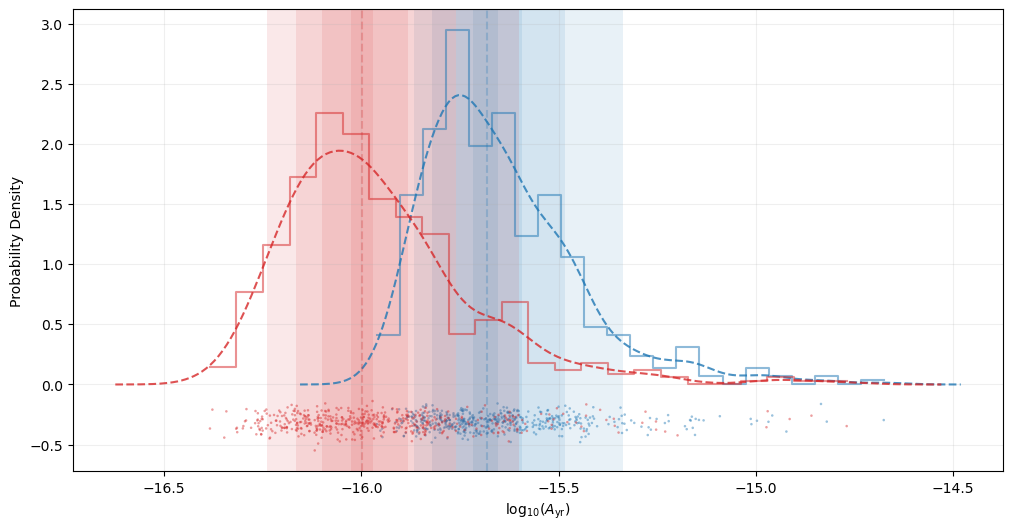

In [8]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.set(xlabel=r'$\log_{10}(A_\mathrm{yr})$', ylabel='Probability Density')
ax.grid(alpha=0.2)

# use `kalepy` do draw the 1D distribution
kale.dist1d(np.log10(apt3yr), density=True, confidence=True)
#comparing the SAM and the full binary population at a single frequency (yr^-1)
kale.dist1d(np.log10(gwtot_samp_pt3yr), density=True, confidence=True)
plt.show()

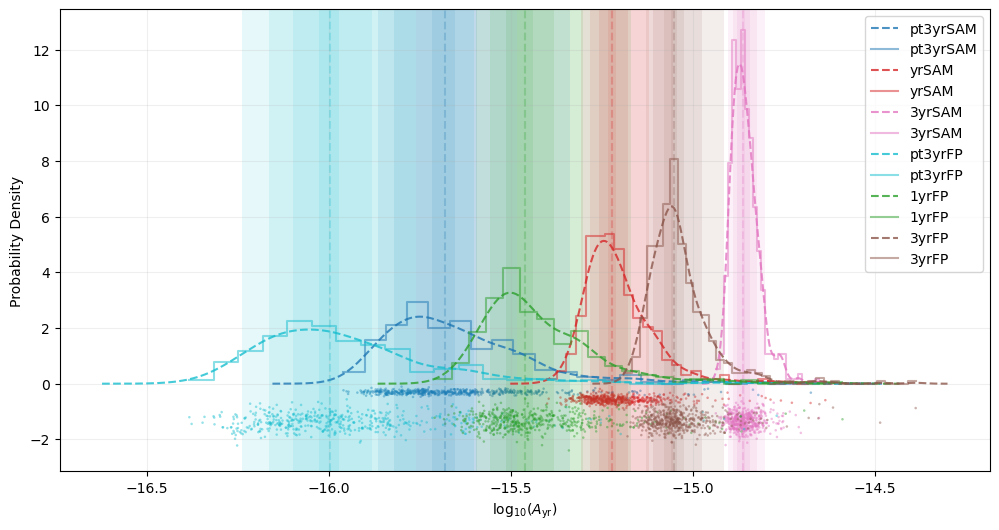

In [16]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.set(xlabel=r'$\log_{10}(A_\mathrm{yr})$', ylabel='Probability Density')
ax.grid(alpha=0.2)

# use `kalepy` do draw the 1D distribution
kale.dist1d(np.log10(apt3yr), density=True, confidence=True, label='pt3yrSAM')
kale.dist1d(np.log10(ayr), density=True, confidence=True, label='yrSAM')
kale.dist1d(np.log10(a3yr), density=True, confidence=True, label='3yrSAM')

#comparing the SAM and the full binary population at a single frequency (yr^-1)
kale.dist1d(np.log10(gwtot_samp_pt3yr), density=True, confidence=True, label='pt3yrFP')
kale.dist1d(np.log10(gwtot_samp_yr), density=True, confidence=True, label='1yrFP')
kale.dist1d(np.log10(gwtot_samp_3yr), density=True, confidence=True, label='3yrFP')
plt.legend()
plt.show()